In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.datasets import make_regression,make_classification

In [2]:
df = pd.read_csv('./archive/cox-violent-parsed_filt.csv')

print(df.shape)

(18316, 40)


In [3]:
df.count()

id                         11001
name                       18316
first                      18316
last                       18316
sex                        18316
dob                        18316
age                        18316
age_cat                    18316
race                       18316
juv_fel_count              18316
decile_score               18316
juv_misd_count             18316
juv_other_count            18316
priors_count               18316
days_b_screening_arrest    17019
c_jail_in                  17019
c_jail_out                 17019
c_days_from_compas         17449
c_charge_degree            17449
c_charge_desc              17435
is_recid                   18316
r_charge_degree             8417
r_days_from_arrest          6359
r_offense_date              8417
r_charge_desc               8277
r_jail_in                   6359
violent_recid                  0
is_violent_recid           18316
vr_charge_degree            1339
vr_offense_date             1339
vr_charge_

In [4]:
df.select_dtypes(exclude='number').head()

,name,first,last,sex,dob,age_cat,race,c_jail_in,c_jail_out,c_charge_degree,...,r_charge_desc,r_jail_in,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_score_text
0,miguel hernandez,miguel,hernandez,Male,18/04/1947,Greater than 45,Other,13/08/2013 6:03,14/08/2013 5:41,(F3),...,NaN,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,Low
1,miguel hernandez,miguel,hernandez,Male,18/04/1947,Greater than 45,Other,13/08/2013 6:03,14/08/2013 5:41,(F3),...,NaN,NaN,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,Low
2,michael ryan,michael,ryan,Male,06/02/1985,25 - 45,Caucasian,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Risk of Recidivism,Medium,31/12/2014,Risk of Violence,Low
3,kevon dixon,kevon,dixon,Male,22/01/1982,25 - 45,African-American,26/01/2013 3:45,05/02/2013 5:36,(F3),...,Felony Battery (Dom Strang),NaN,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,Low,27/01/2013,Risk of Violence,Low
4,ed philo,ed,philo,Male,14/05/1991,Less than 25,African-American,13/04/2013 4:58,14/04/2013 7:02,(F3),...,Driving Under The Influence,16/06/2013,NaN,NaN,NaN,Risk of Recidivism,Low,14/04/2013,Risk of Violence,Low


In [5]:
df.describe(exclude='number')

,name,first,last,sex,dob,age_cat,race,c_jail_in,c_jail_out,c_charge_degree,...,r_charge_desc,r_jail_in,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_score_text
count,18316,18316,18316,18316,18316,18316,18316,17019,17019,17449,...,8277,6359,1339,1339,1339,18316,18293,18316,18316,18310
unique,10855,3876,5635,2,7485,3,6,9806,8714,14,...,341,972,9,570,83,1,3,703,1,3
top,brandon ross,michael,williams,Male,21/11/1991,25 - 45,African-American,04/02/2013 7:24,30/04/2013 7:29,(F3),...,Possess Cannabis/20 Grams Or Less,29/04/2014,(M1),06/01/2015,Battery,Risk of Recidivism,Low,20/03/2013,Risk of Violence,Low
freq,13,421,239,14933,21,10372,9791,13,19,10294,...,635,29,550,14,529,18316,8597,72,18316,11147


In [6]:
#count occurrences of each race
race_counts = df['race'].value_counts()

print(race_counts)

race
African-American    9791
Caucasian           6086
Hispanic            1451
Other                860
Asian                 71
Native American       57
Name: count, dtype: int64


In [7]:
#count people still in jail
in_jail_count = df[(df['c_jail_in'].notna())]

print(in_jail_count)

        id                   name       first        last     sex         dob  \
0      1.0       miguel hernandez      miguel   hernandez    Male  18/04/1947   
1      2.0       miguel hernandez      miguel   hernandez    Male  18/04/1947   
3      4.0            kevon dixon       kevon       dixon    Male  22/01/1982   
4      5.0               ed philo          ed       philo    Male  14/05/1991   
5      6.0               ed philo          ed       philo    Male  14/05/1991   
...    ...                    ...         ...         ...     ...         ...   
18311  NaN  alexsandra beauchamps  alexsandra  beauchamps  Female  21/12/1984   
18312  NaN        winston gregory     winston     gregory    Male  01/10/1958   
18313  NaN            farrah jean      farrah        jean  Female  17/11/1982   
18314  NaN    florencia sanmartin   florencia   sanmartin  Female  18/12/1992   
18315  NaN    florencia sanmartin   florencia   sanmartin  Female  18/12/1992   

       age          age_cat

In [8]:
#count the number of people in jail by race
race_jail_count = in_jail_count['race'].value_counts()

print(race_jail_count)

race
African-American    9161
Caucasian           5664
Hispanic            1278
Other                805
Asian                 64
Native American       47
Name: count, dtype: int64


/tmp/ipykernel_11431/746455533.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_jail_count.index,y=race_jail_count.values, palette='viridis')


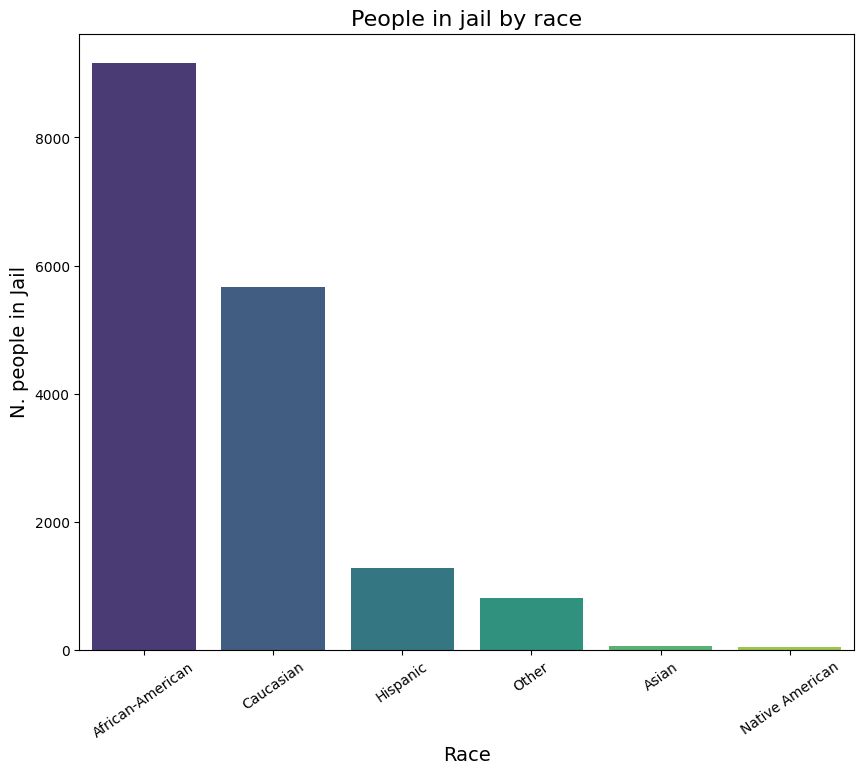

In [9]:
plt.figure(figsize=(10,8))
sns.barplot(x=race_jail_count.index,y=race_jail_count.values, palette='viridis')

plt.xlabel("Race", fontsize=14)
plt.ylabel("N. people in Jail", fontsize=14)
plt.title("People in jail by race", fontsize=16)
plt.xticks(rotation=35)

plt.show()

In [10]:
#how many people get re-arrested?

recidivism_count = df['is_recid'].value_counts()

print(recidivism_count)

is_recid
 0    9079
 1    8417
-1     820
Name: count, dtype: int64


In [11]:
#...by race

# recidivism_by_race = df.groupby('race')['is_recid'].mean()
recidivism_by_race = df.groupby('race')['is_recid'].value_counts()
print(recidivism_by_race)

race              is_recid
African-American   1          5081
                   0          4338
                  -1           372
Asian              0            45
                   1            19
                  -1             7
Caucasian          0          3308
                   1          2474
                  -1           304
Hispanic           0           860
                   1           495
                  -1            96
Native American    0            26
                   1            25
                  -1             6
Other              0           502
                   1           323
                  -1            35
Name: count, dtype: int64


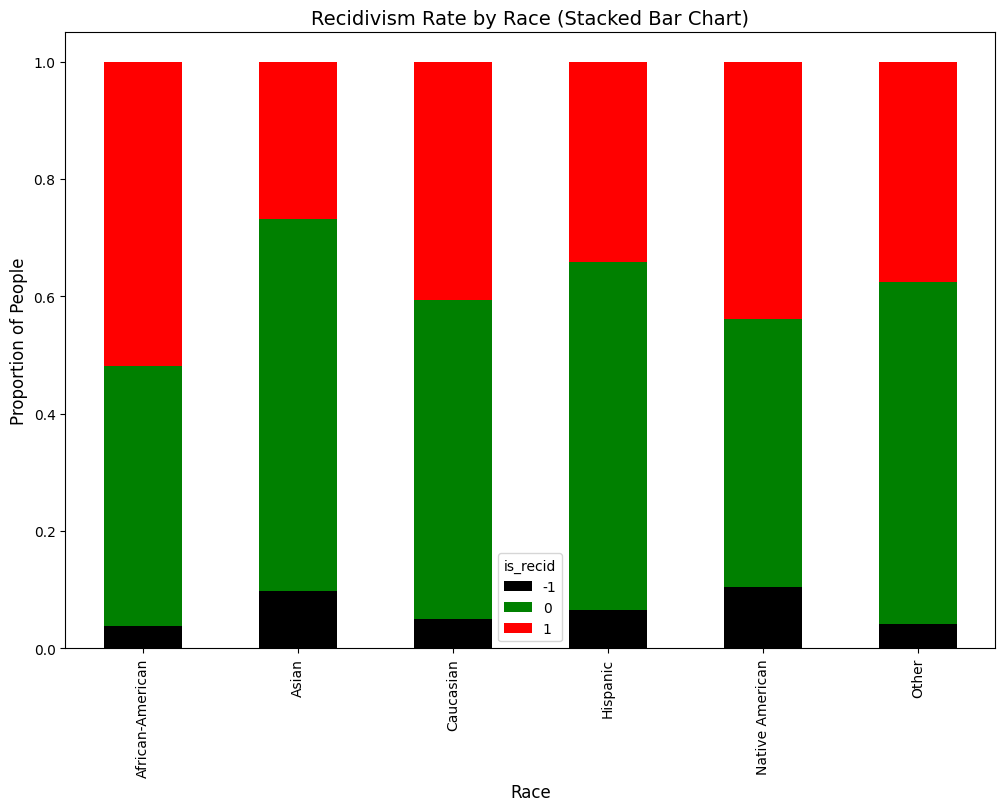

In [12]:
# Group by race and recidivism, then normalize to get percentages
recid_by_race = df.groupby(['race', 'is_recid']).size().unstack().fillna(0)
recid_by_race = recid_by_race.div(recid_by_race.sum(axis=1), axis=0)  # Normalize by row (race)

# Plot stacked bar chart
recid_by_race.plot(kind='bar', stacked=True, figsize=(12, 8), color=["black", "green", "red"])

plt.xlabel("Race", fontsize=12)
plt.ylabel("Proportion of People", fontsize=12)
plt.title("Recidivism Rate by Race (Stacked Bar Chart)", fontsize=14)

plt.show()


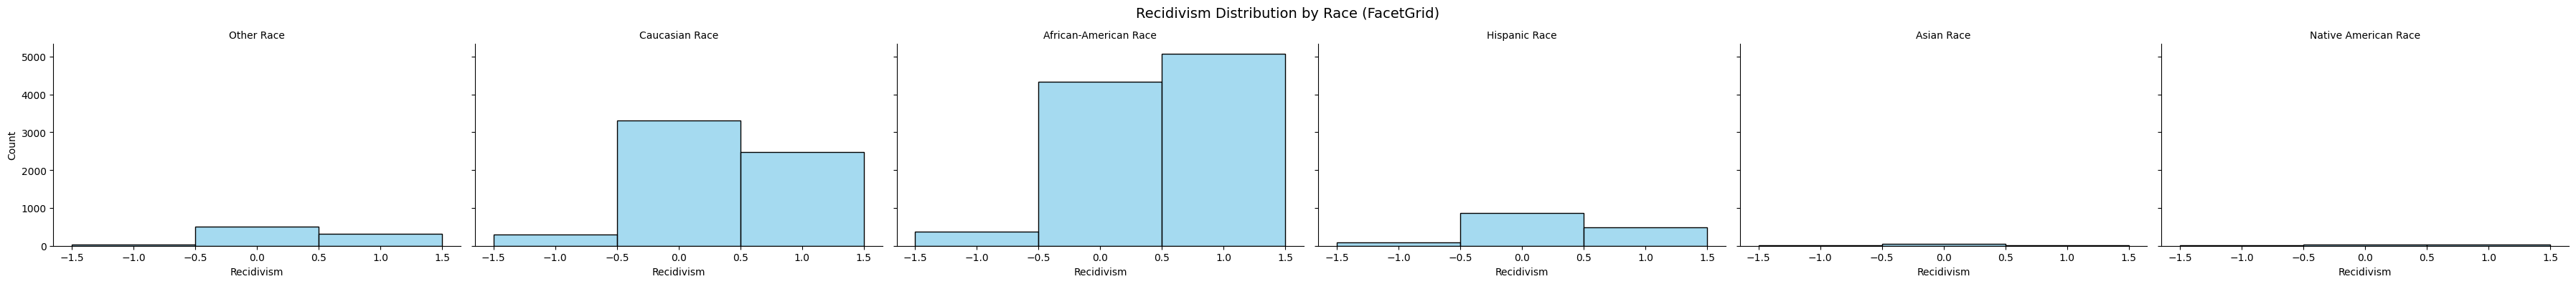

In [13]:
g = sns.FacetGrid(df, col="race", height=4, aspect=1.5)
g.map(sns.histplot, 'is_recid', discrete=True, color="skyblue")

g.set_axis_labels("Recidivism", "Count")
g.set_titles("{col_name} Race")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Recidivism Distribution by Race (FacetGrid)", fontsize=14)

plt.show()

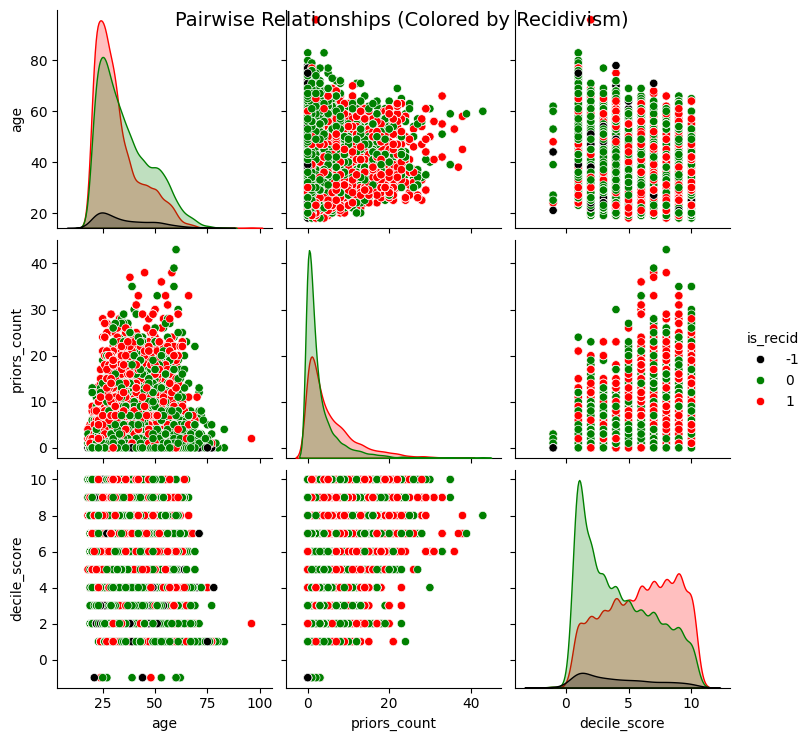

In [14]:
palette = {-1: "black", 0: "green", 1: "red"}

sns.pairplot(df[['age', 'priors_count', 'decile_score', 'is_recid']], hue="is_recid", palette=palette)

plt.suptitle("Pairwise Relationships (Colored by Recidivism)", fontsize=14)
plt.show()


/tmp/ipykernel_11431/3756652364.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='race', y='decile_score', data=avg_decile_by_race, palette="coolwarm")


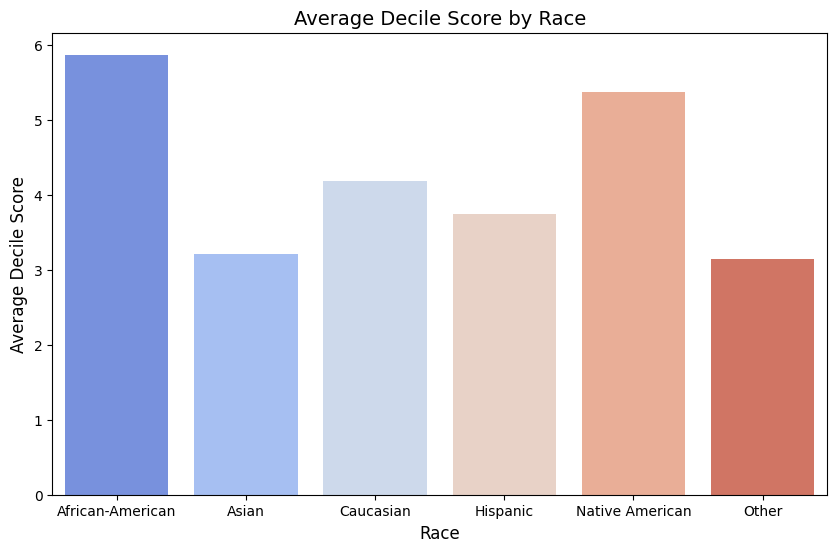

In [15]:
# Calculate the average decile score by race
avg_decile_by_race = df.groupby('race')['decile_score'].mean().reset_index()

# Create a bar plot for average decile score by race
plt.figure(figsize=(10, 6))
sns.barplot(x='race', y='decile_score', data=avg_decile_by_race, palette="coolwarm")

plt.xlabel("Race", fontsize=12)
plt.ylabel("Average Decile Score", fontsize=12)
plt.title("Average Decile Score by Race", fontsize=14)
plt.show()


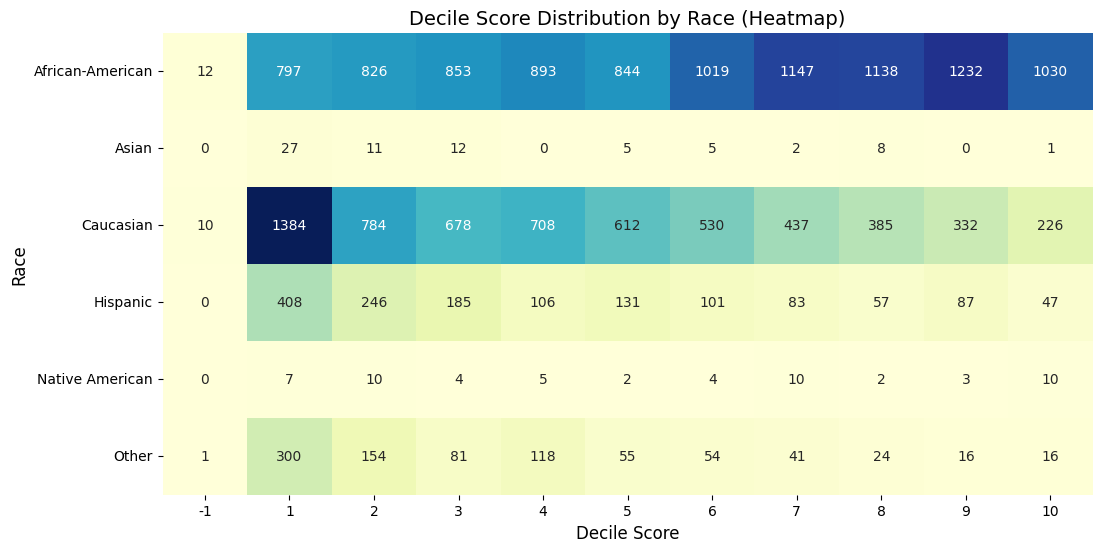

In [16]:
# Create a pivot table for the decile score counts by race
decile_heatmap_data = pd.crosstab(df['race'], df['decile_score'])

# Create a heatmap for decile score distribution by race
plt.figure(figsize=(12, 6))
sns.heatmap(decile_heatmap_data, cmap="YlGnBu", annot=True, fmt='d', cbar=False)

plt.xlabel("Decile Score", fontsize=12)
plt.ylabel("Race", fontsize=12)
plt.title("Decile Score Distribution by Race (Heatmap)", fontsize=14)
plt.show()


/tmp/ipykernel_11431/2302836108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)


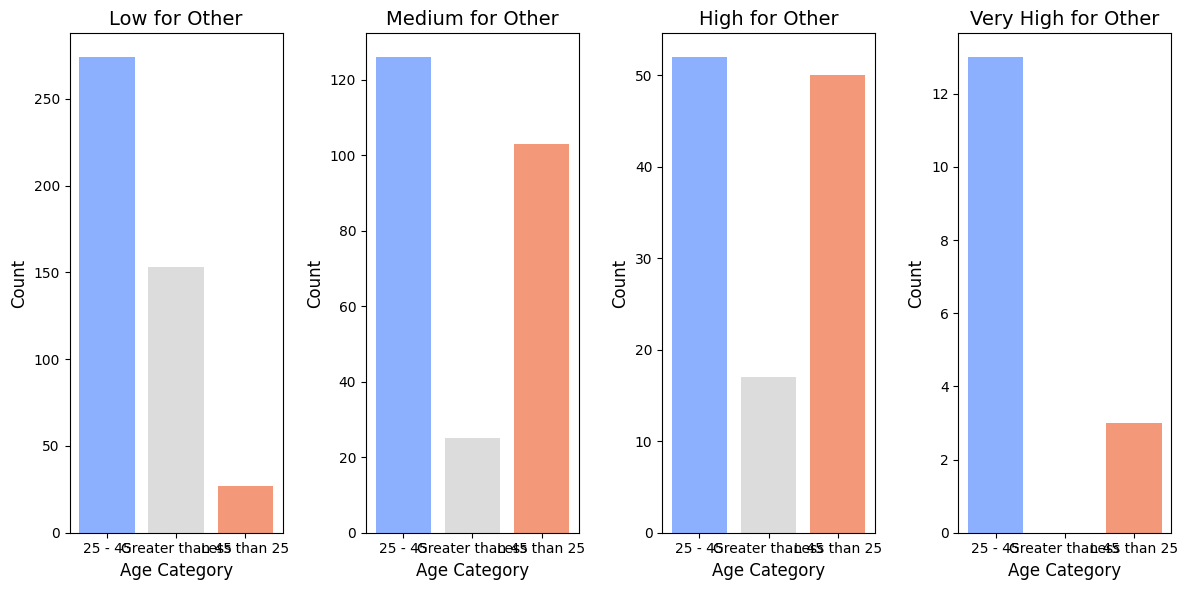

/tmp/ipykernel_11431/2302836108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)


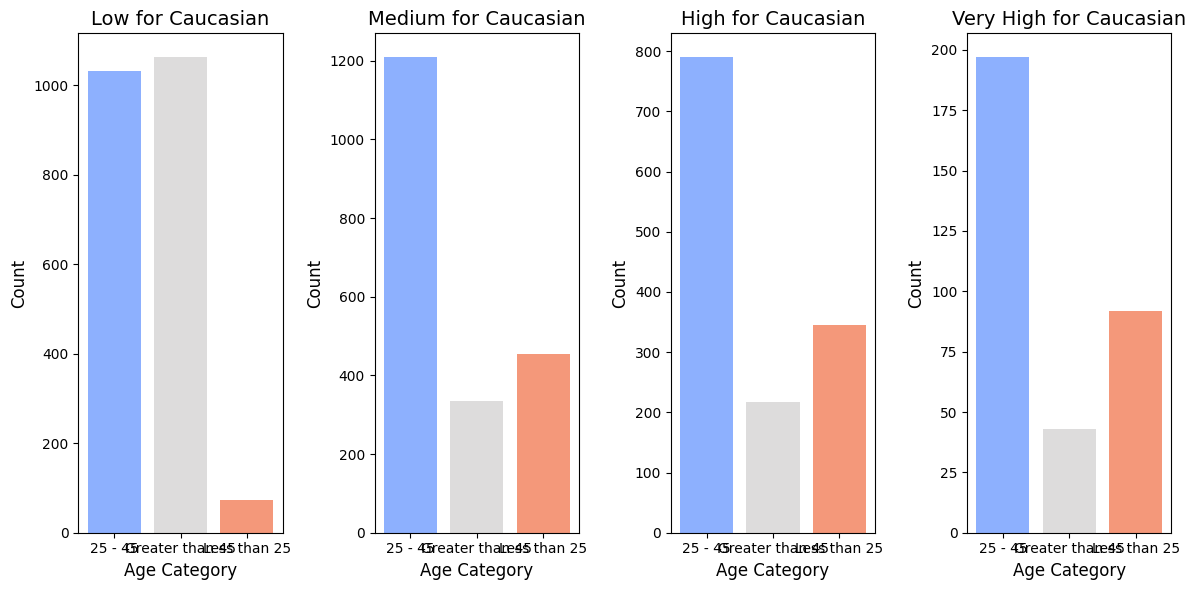

/tmp/ipykernel_11431/2302836108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)


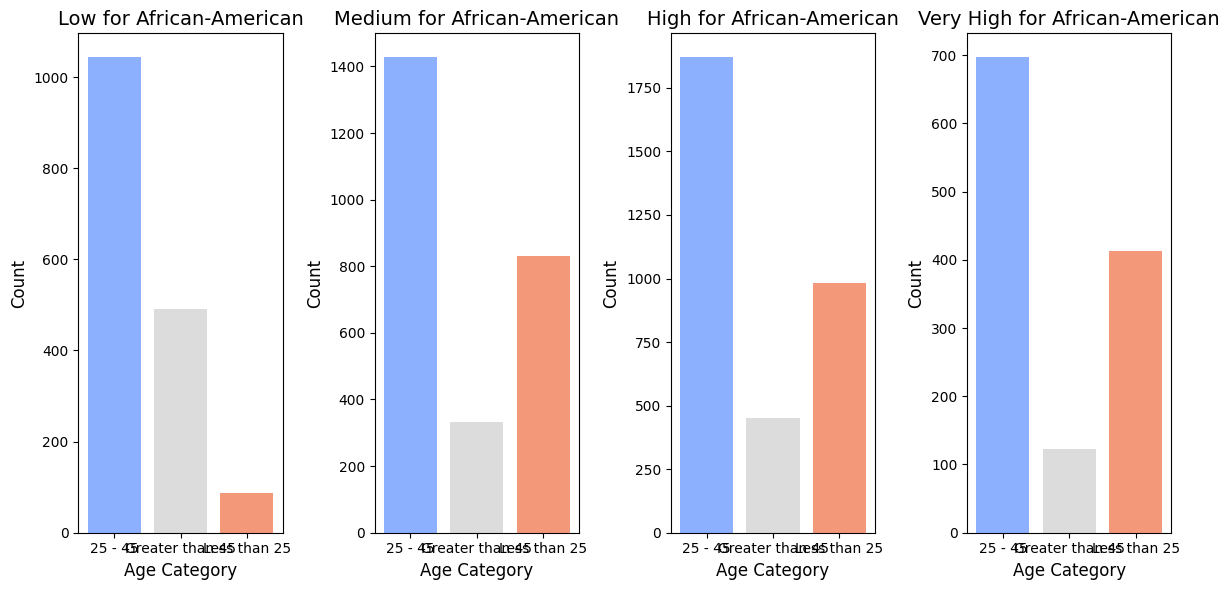

/tmp/ipykernel_11431/2302836108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)


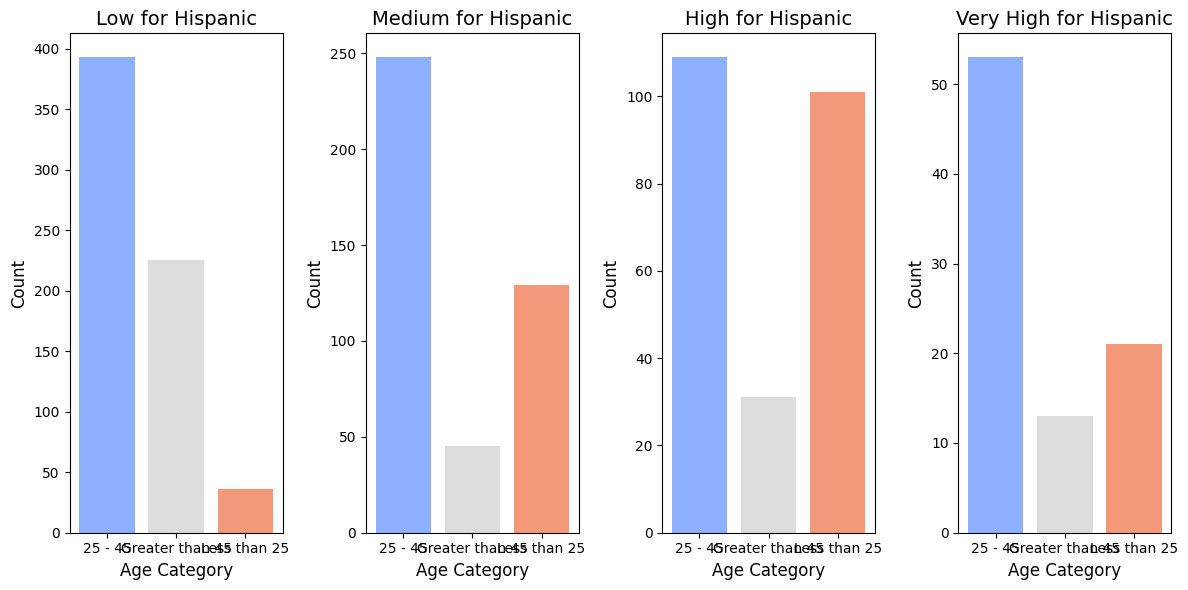

/tmp/ipykernel_11431/2302836108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)


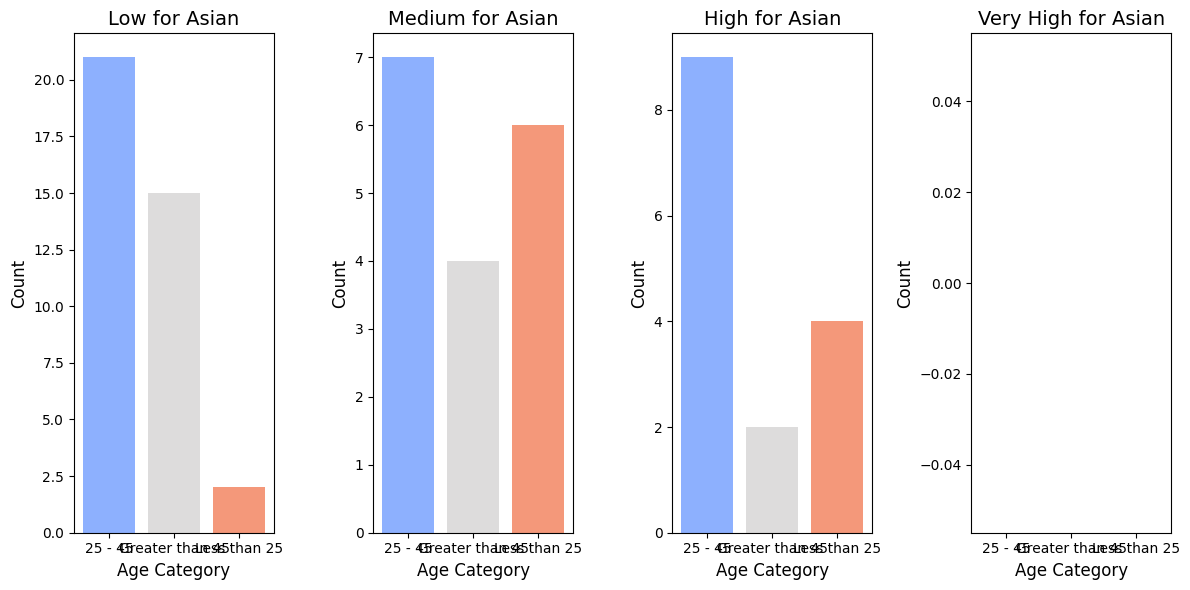

/tmp/ipykernel_11431/2302836108.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)


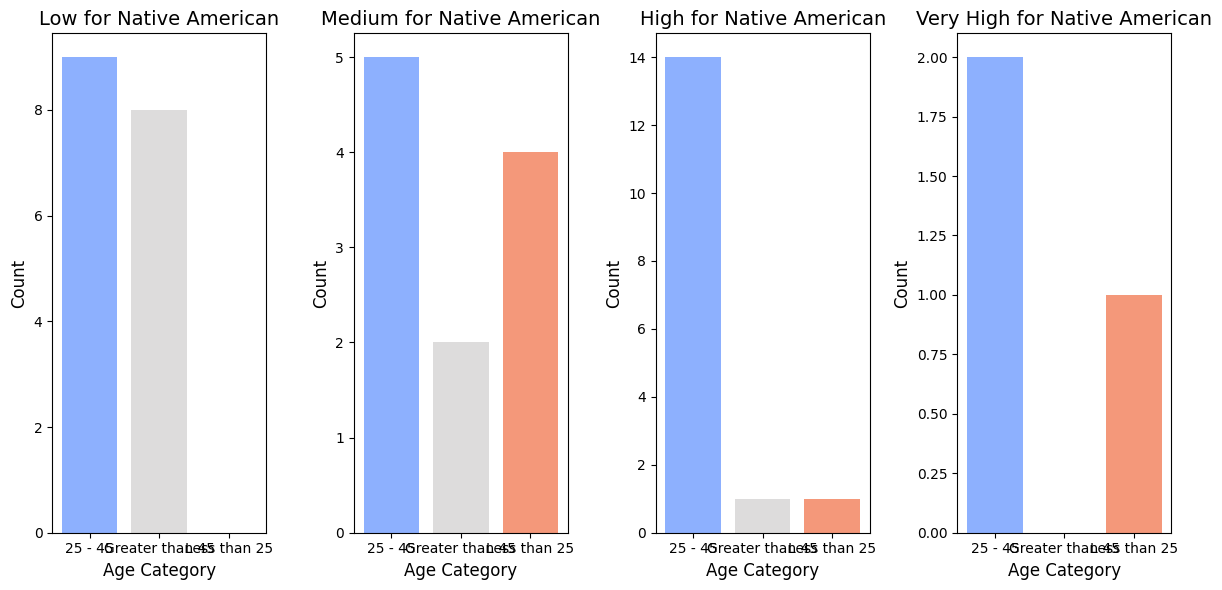

In [31]:
# Step 1: Clean NaN values in 'decile_score' column (you can either fill or drop NaNs)
df = df.dropna(subset=['decile_score'])  # Dropping rows with NaN in decile_score

# Step 2: Create decile score categories (low, medium, high)
bins = [0, 3, 6, 9, 10]  # Define bin edges based on decile score ranges
labels = ['Low', 'Medium', 'High', 'Very High']  # Labels for each range

# Step 3: Apply 'pd.cut()' to categorize 'decile_score'
df['decile_score_range'] = pd.cut(df['decile_score'], bins=bins, labels=labels, right=False)

# Step 4: Get unique races
races = df['race'].unique()

# Step 5: Loop through each race and plot a bar plot for age categories within decile score ranges
for race in races:
    # Filter the dataframe for the current race
    race_data = df[df['race'] == race]
    
    # Step 6: Group by decile_score_range and age_cat, then count the occurrences
    age_decile_counts = race_data.groupby(['decile_score_range', 'age_cat']).size().unstack(fill_value=0)
    
    # Step 7: Create subplots for each race (one row, multiple columns)
    num_plots = len(age_decile_counts.index)  # Number of bar plots for the current race
    fig, axes = plt.subplots(1, num_plots, figsize=(12, 6))  # Create a subplot row with num_plots columns

    # If only one plot, make sure axes is iterable
    if num_plots == 1:
        axes = [axes]

    # Plot one bar plot for each decile score range
    for j, decile_range in enumerate(age_decile_counts.index):
        counts = age_decile_counts.loc[decile_range].fillna(0)
        
        # Ensure all values are finite (replace NaN or inf with 0)
        counts = counts.replace([np.inf, -np.inf, np.nan], 0)

        # Plotting the bar plot for this decile score range
        axes[j].bar(counts.index, counts, color=sns.color_palette("coolwarm", len(counts)))
        axes[j].set_title(f"{decile_range} for {race}", fontsize=14)
        axes[j].set_xlabel('Age Category', fontsize=12)
        axes[j].set_ylabel('Count', fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Show the bar chart row for this race